# New features

In [1]:
from imports import *
%matplotlib inline

In [2]:
df_shapes_log = pd.DataFrame()

## Import datasets processed in previous step

In [3]:
df=pd.read_hdf(config.df_new_features, 'df')
df_test=pd.read_hdf(config.df_test_new_features, 'df')

## Analyze which features should be removed

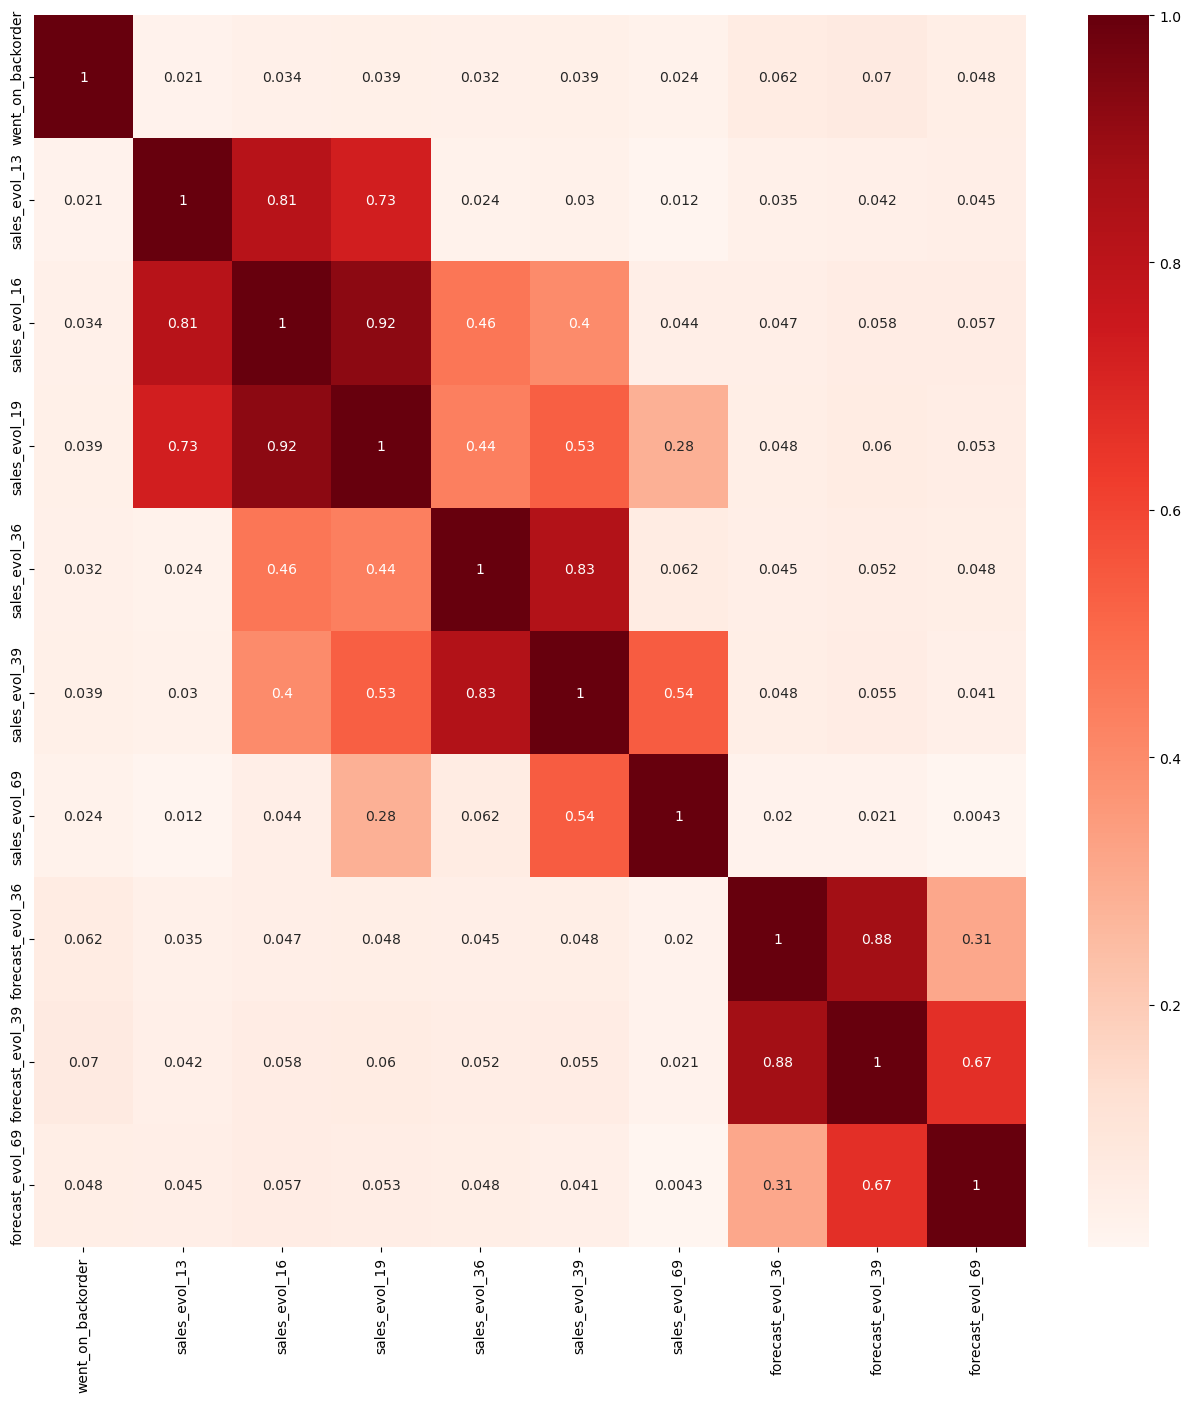

In [4]:
plt.figure(figsize=(16,16))
cor = df[['went_on_backorder','sales_evol_13','sales_evol_16','sales_evol_19','sales_evol_36','sales_evol_39','sales_evol_69','forecast_evol_36','forecast_evol_39','forecast_evol_69' ]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

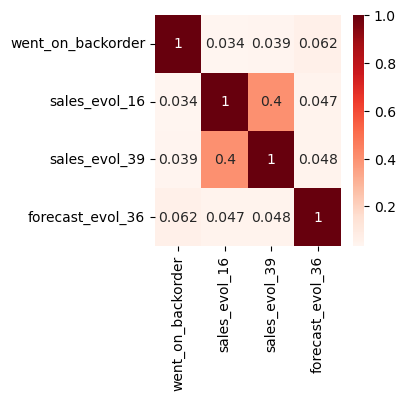

In [5]:
plt.figure(figsize=(3,3))
cor = df[['went_on_backorder','sales_evol_16','sales_evol_39','forecast_evol_36']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [6]:
X_train = df.drop(columns=[config.y_column])
y_train = df[config.y_column]

X_train['lead_time'] = X_train['lead_time'].fillna(df['lead_time'].mean())
X_train['perf_6_month_avg'] = X_train['perf_6_month_avg'].fillna(df['perf_6_month_avg'].mean())
X_train['perf_12_month_avg'] = X_train['perf_12_month_avg'].fillna(df['perf_12_month_avg'].mean())

# from pipeline_functions import *

# X_scaled_std = CustomScaler(CustomScalerType.STANDARD).fit_transform(X_no_missing_values)

# pca = PCA()
# X_pca_min_max = pca.fit_transform(X_scaled_min_max)
# X_pca_std = pca.fit_transform(X_scaled_std)

In [7]:
X_train

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,national_inv_neg,forecast_evol_36,forecast_evol_39,forecast_evol_69,sales_evol_13,sales_evol_16,sales_evol_19,sales_evol_36,sales_evol_39,sales_evol_69
0,0.0,2.144192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.0,2.408225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2.0,2.144192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,7.0,2.297397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.0,2.144192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687855,0.0,1.319508,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,...,0,1.000000,2.000000,0.500000,-1.000000,-1.000000,-1.000000,0.428571,1.142857,0.500000
1687856,-1.0,2.144192,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,...,1,0.428571,0.666667,0.166667,0.000000,1.000000,0.125000,1.000000,0.125000,-0.437500
1687857,-1.0,2.408225,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,...,1,0.555556,0.909091,0.227273,-1.000000,-1.000000,-1.000000,0.454545,1.000000,0.375000
1687858,62.0,2.408225,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,...,0,-0.103448,-0.071429,0.035714,0.666667,0.372549,0.536585,-0.176471,-0.078049,0.119512


In [8]:
num_vars = [feature for feature in df.columns if df[feature].dtypes == 'float64']
cat_vars = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk','stop_auto_buy', 'rev_stop']

In [9]:
cat_vars = ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk','stop_auto_buy', 'rev_stop']
cat_vars

['potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop']

### Using VIF (Variance Inflation Factor) to select the best features

In [10]:
# compute the vif for all given features
def compute_vif(X, considered_features):
    
    X_ = X[considered_features]
    # the calculation of variance inflation requires a constant
    X_['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X_.columns
    vif["VIF"] = [variance_inflation_factor(X_.values, i) for i in range(X_.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

Features to consider removing throw VIF execution

In [11]:
considered_features = ['forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'perf_6_month_avg', "perf_12_month_avg", 'min_bank', 'in_transit_qty']

First compute VIF

In [12]:
compute_vif(X_train,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
1,forecast_6_month,472.949697
2,forecast_9_month,262.058079
0,forecast_3_month,91.485347
5,sales_6_month,87.583282
4,sales_3_month,51.920112
6,sales_9_month,20.707873
3,sales_1_month,7.570610
7,perf_6_month_avg,7.552765
8,perf_12_month_avg,7.552382
9,min_bank,5.338385


Compute vif values after removing  `forecast_6_month`

In [13]:
considered_features.remove('forecast_6_month')
compute_vif(X_train,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
4,sales_6_month,86.930005
1,forecast_9_month,51.545031
3,sales_3_month,51.517870
0,forecast_3_month,31.991539
5,sales_9_month,20.707735
6,perf_6_month_avg,7.552726
7,perf_12_month_avg,7.552337
2,sales_1_month,7.533336
8,min_bank,5.098321
9,in_transit_qty,2.569156


Compute vif values after removing `sales_6_month`

In [14]:
considered_features.remove('sales_6_month')
compute_vif(X_train,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
1,forecast_9_month,42.039903
0,forecast_3_month,29.391607
3,sales_3_month,22.361551
4,sales_9_month,11.558340
5,perf_6_month_avg,7.552656
6,perf_12_month_avg,7.552145
2,sales_1_month,7.360056
7,min_bank,5.084814
8,in_transit_qty,2.533810


Compute vif values after removing `forecast_9_month`

In [15]:
considered_features.remove('forecast_9_month')
compute_vif(X_train,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
2,sales_3_month,21.206685
3,sales_9_month,9.639230
4,perf_6_month_avg,7.552492
5,perf_12_month_avg,7.552118
1,sales_1_month,7.010433
6,min_bank,4.607426
0,forecast_3_month,3.427289
7,in_transit_qty,2.472668


Compute vif values after removing `sales_3_month`

In [16]:
considered_features.remove('sales_3_month')
compute_vif(X_train,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
3,perf_6_month_avg,7.552492
4,perf_12_month_avg,7.552099
2,sales_9_month,5.507865
5,min_bank,3.925688
0,forecast_3_month,3.422043
1,sales_1_month,3.292670
6,in_transit_qty,2.460400


Compute vif values after removing `perf_6_month_avg`

In [17]:
considered_features.remove('perf_6_month_avg')
compute_vif(X_train,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
2,sales_9_month,5.507589
4,min_bank,3.925660
0,forecast_3_month,3.422006
1,sales_1_month,3.292669
5,in_transit_qty,2.460393
3,perf_12_month_avg,1.000072


Compute vif values after removing `sales_9_month`

In [18]:
considered_features.remove('sales_9_month')
compute_vif(X_train,considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
3,min_bank,3.604060
1,sales_1_month,2.575272
0,forecast_3_month,2.458840
4,in_transit_qty,2.457614
2,perf_12_month_avg,1.000065


###  RFE (Numerical Features) and Chi-Squared (Categorical Features) 

In [19]:
def select_best_features(X, y, n_splits = 10, rfe_n_features_to_select = 0.75):
    rfe_columns = num_vars + cat_vars
    chi2_columns = cat_vars

    rfe_results = [0] * len(rfe_columns)
    chi2_results = {chi2_columns[i]: 0 for i in range(len(chi2_columns))}

    skf = StratifiedKFold(n_splits)
    counter = 0
    for train_index, val_index in skf.split(X, y):
        counter +=1
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        # get all numerical variables
        X_train_rfe = X_train[rfe_columns]
        # X_val_num = X_val[rfe_columns]
        
        # get all categorical variables
        X_train_cat = X_train[chi2_columns]
        # X_val_cat = X_val[cat_vars]
        
        # Apply scaling to numerical data
        scaler = MinMaxScaler().fit(X_train_rfe)
        X_train_scaled = pd.DataFrame(scaler.transform(X_train_rfe), columns = X_train_rfe.columns, index = X_train_rfe.index,) # MinMaxScaler in the training data
        
        # Check which features to use using RFE
        model = LogisticRegression()
        rfe = RFE(estimator = model, n_features_to_select= rfe_n_features_to_select)
        X_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)
        for i,r in enumerate(rfe.support_):
            if r: rfe_results[i] = rfe_results[i] + 1
        # selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
        # print(selected_features)
        
        # Check which features to use using Chi-Square
        def TestIndependence(X,y,var,alpha=0.05):        
            dfObserved = pd.crosstab(y,X) 
            chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
            dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
            if p<alpha:
                chi2_results[var] = chi2_results[var] + 1
        
        for var in X_train_cat:
            TestIndependence(X_train_cat[var],y_train, var)
    
    
    rfe_results =  pd.DataFrame(rfe_results, index=rfe_columns, columns = ['Qty_Selected_By_Rfe']).copy().sort_values(['Qty_Selected_By_Rfe'], ascending=False)
    chi2_results = pd.DataFrame(chi2_results.values(), index=chi2_results.keys(), columns = ['Qty_Selected_By_Chi2']).copy().sort_values(['Qty_Selected_By_Chi2'], ascending=False)

    # sns.countplot(y = 'Qty_Selected_By_Rfe', data = rfe_results)
    plt.figure(figsize=(10, min(10,len(rfe_results) / 2 )))
    plt.title(f'Feature importance: RFE (StratifiedKFold K = {n_splits}, Feature to select = {rfe_n_features_to_select})')
    sns.barplot(y=rfe_results.index, x='Qty_Selected_By_Rfe', data=rfe_results, palette = ['royalblue' for i in rfe_results.index])
    plt.figure(figsize=(10, min(10,len(chi2_results) / 2 )))
    plt.title(f'Feature importance (categorical): Chi2 (StratifiedKFold K = {n_splits})')
    sns.barplot(y=chi2_results.index, x='Qty_Selected_By_Chi2', data=chi2_results, palette = ['royalblue' for i in chi2_results.index])
    return rfe_results, chi2_results

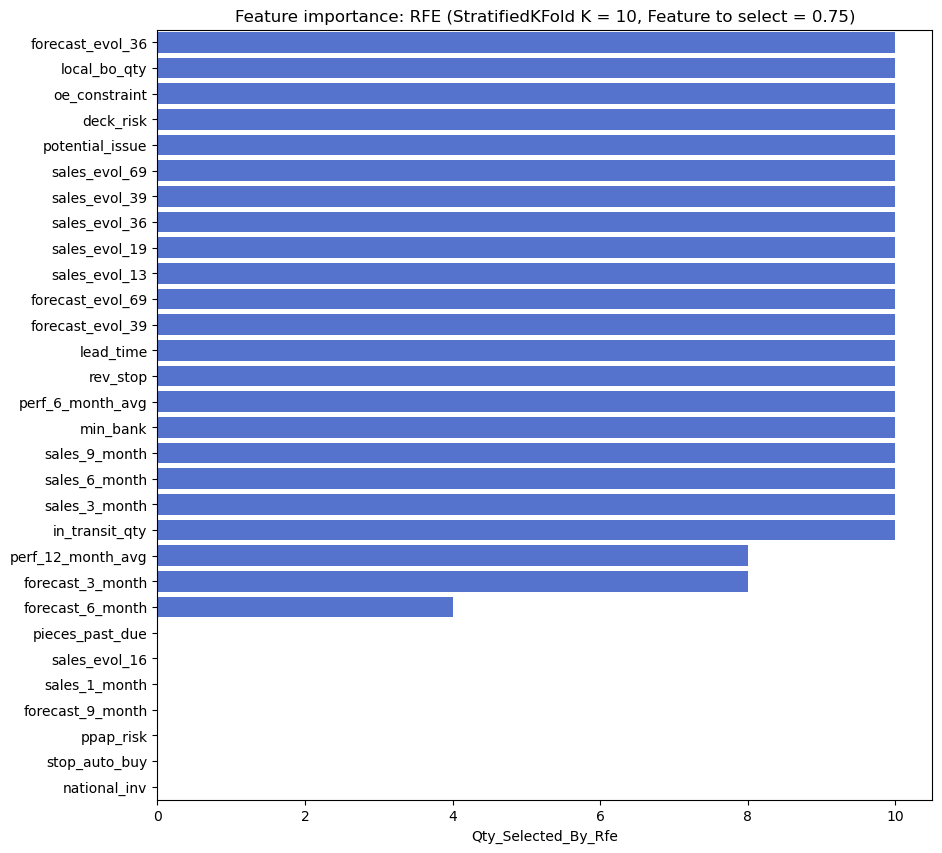

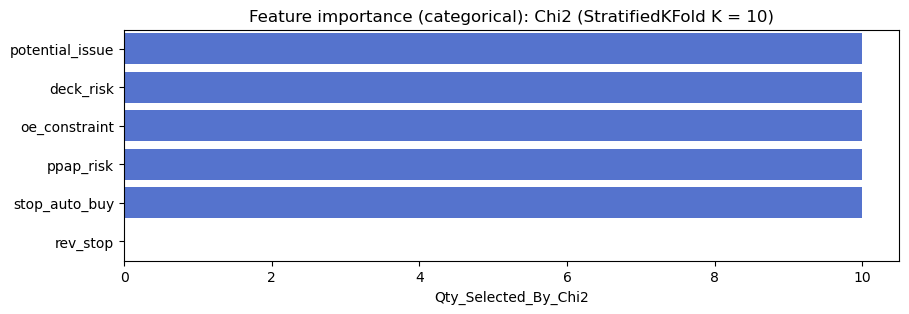

In [20]:
_,_ = select_best_features(X_train,y_train)

### Use decision tree to evaluate feature importance

In [21]:
gini_importance = DecisionTreeClassifier().fit(X_train, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train).feature_importances_
gini_extraTrees_importance =  ExtraTreesClassifier(random_state = 1).fit(X_train, y_train).feature_importances_
entropy_extraTrees_importance =  ExtraTreesClassifier(criterion='entropy').fit(X_train, y_train).feature_importances_

<AxesSubplot: title={'center': 'Feature importance: DecisionTree/ExtraTrees - Gini/Entropy'}, xlabel='Value', ylabel='Features'>

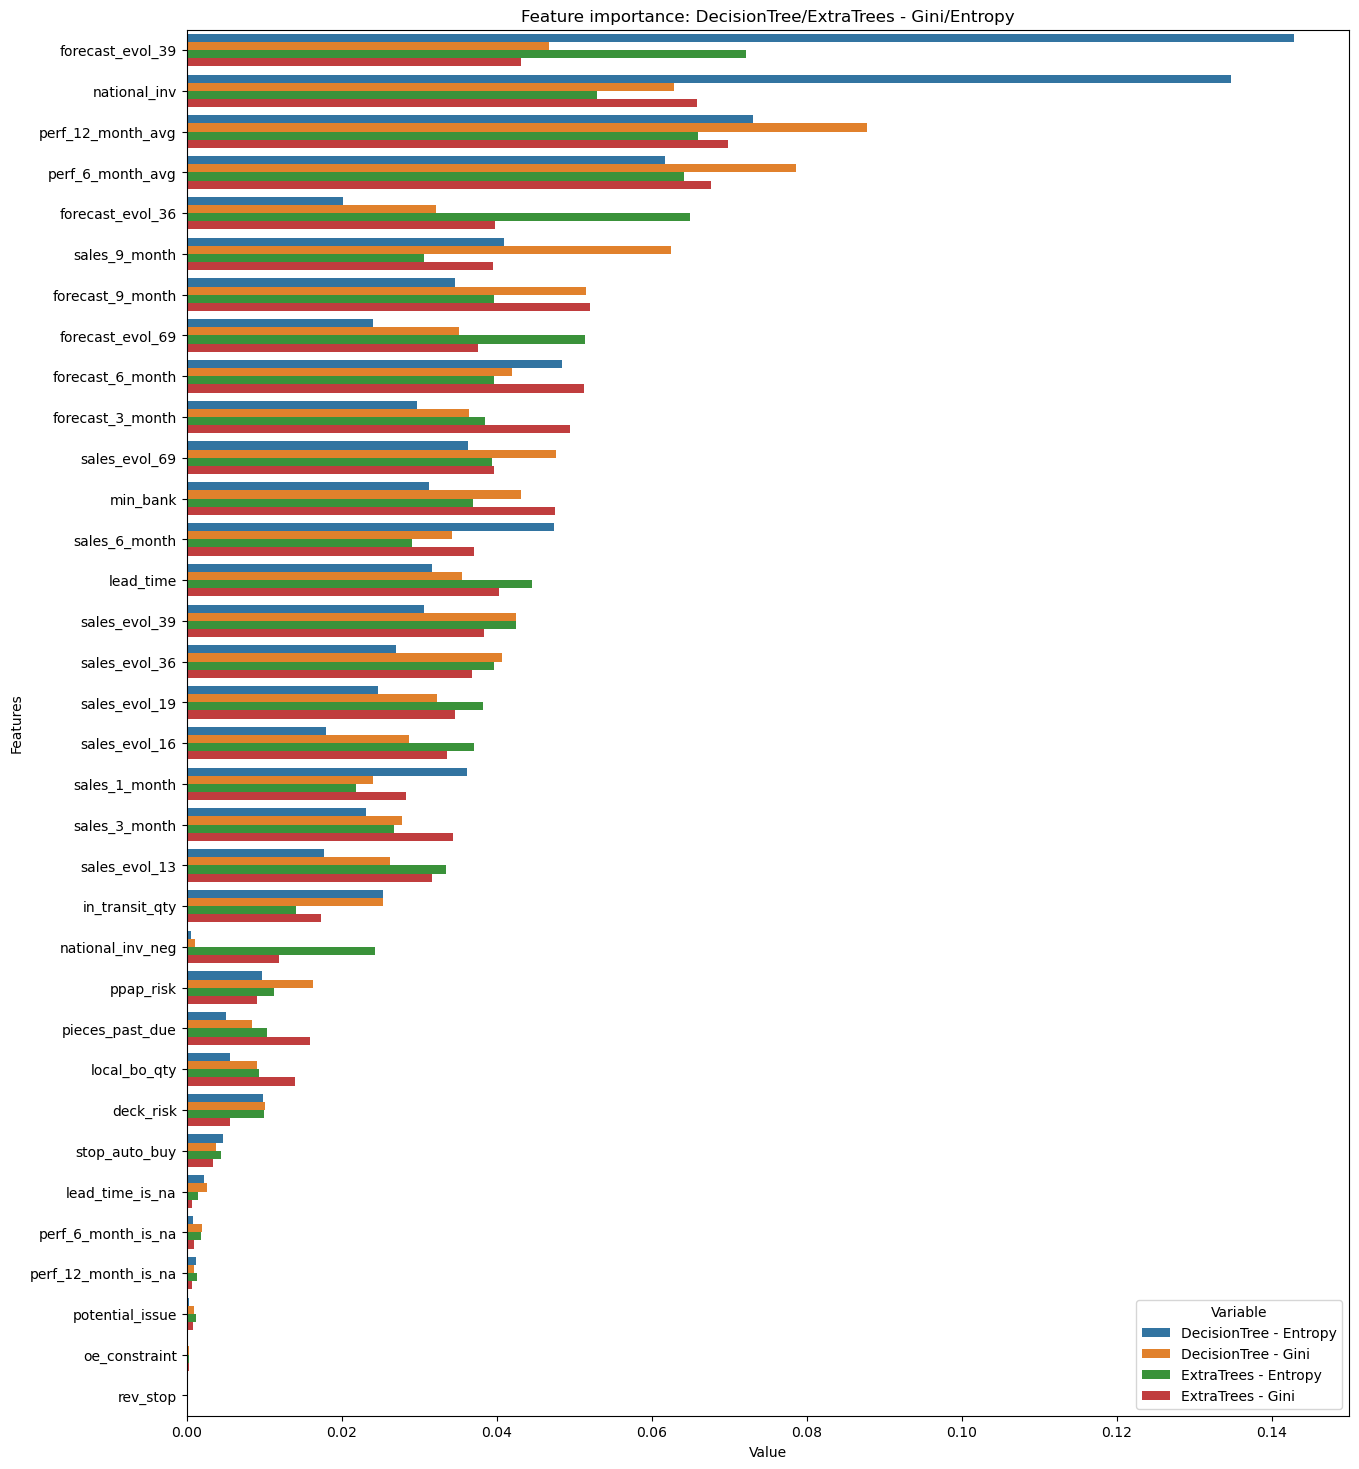

In [22]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance,gini_extraTrees_importance,entropy_extraTrees_importance), columns = ['DecisionTree - Gini','DecisionTree - Entropy','ExtraTrees - Gini','ExtraTrees - Entropy'])
zippy['Features'] = X_train.columns
tidy = zippy.melt(id_vars='Features').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,18))
plt.title(f'Feature importance: DecisionTree/ExtraTrees - Gini/Entropy')
sns.barplot(y='Features', x='Value', hue='Variable', data=tidy)

## Apply choosen feature selection

In [23]:
def feature_selection(d: pd.DataFrame):
    cols_to_drop = [
        'forecast_3_month',
        'forecast_6_month',
        'sales_1_month',
        'sales_3_month',
        'sales_6_month',
        'perf_6_month_avg',
        'perf_6_month_is_na',
        'sales_evol_13',
        'sales_evol_19',
        'sales_evol_36',
        'sales_evol_69',
        'forecast_evol_39',
        'forecast_evol_69' 
    ]
    d.drop(columns=cols_to_drop, inplace=True)

In [24]:
feature_selection(df)
feature_selection(df_test)

In [25]:
df

,national_inv,lead_time,in_transit_qty,forecast_9_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_12_month_avg,local_bo_qty,...,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,perf_12_month_is_na,lead_time_is_na,national_inv_neg,forecast_evol_36,sales_evol_16,sales_evol_39
0,0.0,NaN,0.0,0.0,0.0,0.0,0,0.0,NaN,0.0,...,0,1,0,0,1,1,0,0.000000,0.000000,0.000000
1,2.0,2.408225,0.0,0.0,0.0,0.0,0,0.0,0.99,0.0,...,0,1,0,0,0,0,0,0.000000,0.000000,0.000000
2,2.0,NaN,0.0,0.0,0.0,0.0,0,0.0,NaN,0.0,...,0,1,0,0,1,1,0,0.000000,0.000000,0.000000
3,7.0,2.297397,0.0,0.0,0.0,1.0,0,0.0,0.13,0.0,...,0,1,0,0,0,0,0,0.000000,0.000000,0.000000
4,8.0,NaN,0.0,0.0,4.0,2.0,0,0.0,NaN,0.0,...,0,1,0,0,1,1,0,0.000000,0.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687855,0.0,1.319508,0.0,10.0,7.0,0.0,0,0.0,0.69,5.0,...,0,1,0,0,0,0,0,1.000000,-1.000000,1.142857
1687856,-1.0,NaN,0.0,9.0,8.0,0.0,0,0.0,NaN,1.0,...,0,1,0,0,1,1,1,0.428571,1.000000,0.125000
1687857,-1.0,2.408225,0.0,11.0,12.0,0.0,0,0.0,0.84,1.0,...,0,0,0,1,0,0,1,0.555556,-1.000000,1.000000
1687858,62.0,2.408225,16.0,126.0,205.0,12.0,0,0.0,0.84,6.0,...,0,1,0,0,0,0,0,-0.103448,0.372549,-0.078049


In [26]:
df_test

,national_inv,lead_time,in_transit_qty,forecast_9_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_12_month_avg,local_bo_qty,...,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,perf_12_month_is_na,lead_time_is_na,national_inv_neg,forecast_evol_36,sales_evol_16,sales_evol_39
0,62.0,NaN,0.0,0.0,0.0,1.0,0,0.0,NaN,0.0,...,0,1,0,0,1,1,0,0.0,0.0,0.000000
1,9.0,NaN,0.0,0.0,0.0,1.0,0,0.0,NaN,0.0,...,1,0,0,0,1,1,0,0.0,0.0,0.000000
2,17.0,2.297397,0.0,0.0,0.0,0.0,0,0.0,0.95,0.0,...,0,1,0,0,0,0,0,0.0,0.0,0.000000
3,9.0,1.319508,0.0,0.0,2.0,0.0,0,0.0,0.75,0.0,...,1,1,0,0,0,0,0,0.0,0.0,-1.000000
4,2.0,2.297397,0.0,0.0,0.0,0.0,0,0.0,0.71,0.0,...,0,1,0,0,0,0,0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242070,12.0,2.701920,0.0,0.0,0.0,1.0,0,0.0,0.48,0.0,...,0,1,0,0,0,0,0,0.0,0.0,0.000000
242071,13.0,2.701920,0.0,0.0,0.0,1.0,0,0.0,0.48,0.0,...,0,1,0,0,0,0,0,0.0,0.0,0.000000
242072,13.0,2.701920,0.0,0.0,0.0,1.0,0,0.0,0.48,0.0,...,0,1,0,0,0,0,0,0.0,0.0,0.000000
242073,10.0,2.701920,0.0,0.0,0.0,1.0,0,0.0,0.48,0.0,...,0,1,0,0,0,0,0,0.0,0.0,0.000000


## Export processed datasets

In [27]:
df.to_hdf(config.df_features_selections, 'df', 'w')
df_test.to_hdf(config.df_test_features_selections, 'df', 'w')

## PCA Analysis
Determination of the number of PCA components needed for 95% variance explanation for each of the 2 possible data scaling methods. It will be used during PCA step in final pipeline.

Number of components for 0.95 cumulative variance explained: 8
    Component  Eigenvalue         Diff. Var. explained (%)  \
0           1    0.197221  0.000000e+00           0.320858   
1           2    0.106341 -9.087971e-02           0.173006   
2           3    0.104385 -1.956254e-03           0.169823   
3           4    0.048857 -5.552759e-02           0.079486   
4           5    0.048324 -5.331759e-04           0.078618   
5           6    0.034733 -1.359157e-02           0.056506   
6           7    0.031248 -3.484792e-03           0.050837   
7           8    0.017591 -1.365726e-02           0.028618   
8           9    0.015460 -2.130761e-03           0.025151   
9          10    0.005878 -9.581403e-03           0.009563   
10         11    0.003443 -2.435754e-03           0.005601   
11         12    0.000537 -2.905863e-03           0.000873   
12         13    0.000431 -1.056063e-04           0.000701   
13         14    0.000145 -2.861384e-04           0.000236   
14     

17

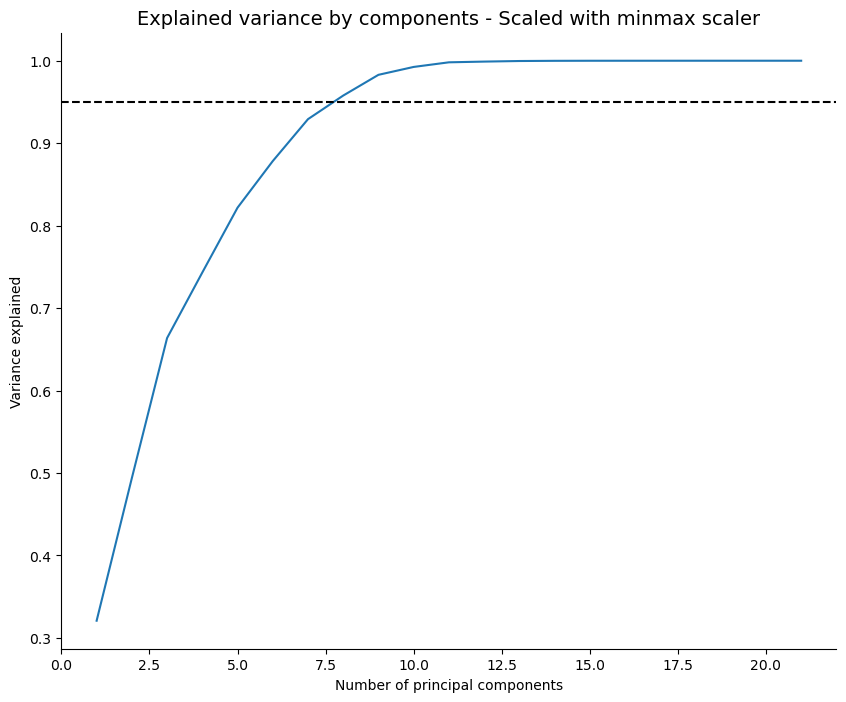

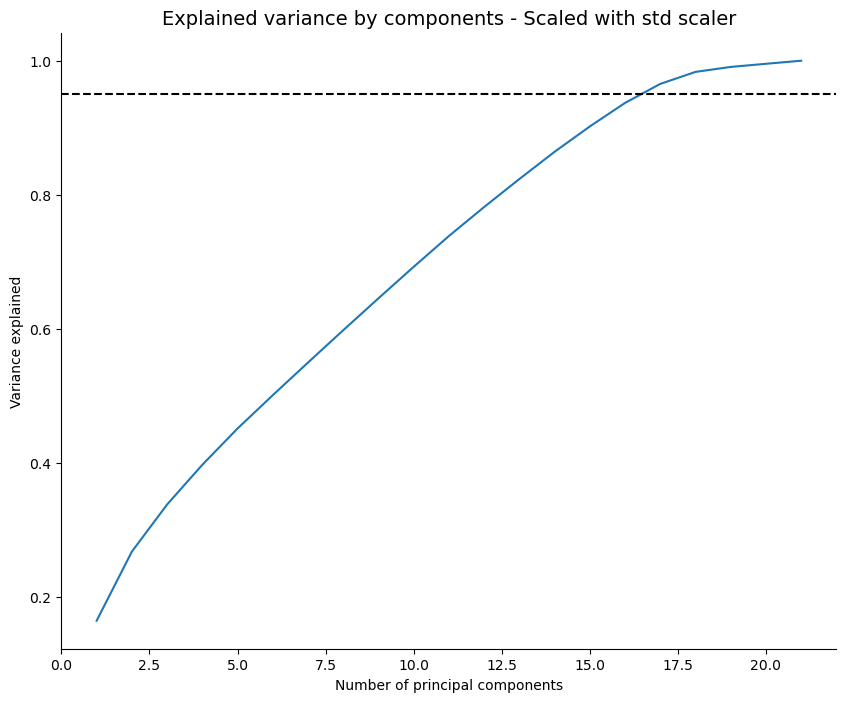

In [28]:
X = df.drop(columns=[config.y_column])
y = df[config.y_column]

simple_imputer = SimpleImputer(strategy='median')
X_no_missing_values = simple_imputer.fit_transform(X)

from pipeline_functions import *

X_scaled_min_max = CustomScaler(CustomScalerType.MINMAX).fit_transform(X_no_missing_values)
X_scaled_std = CustomScaler(CustomScalerType.STANDARD).fit_transform(X_no_missing_values)

pca = PCA()
X_pca_min_max = pca.fit_transform(X_scaled_min_max)
X_pca_std = pca.fit_transform(X_scaled_std)


fn.analyse_pca_fit(pd.DataFrame(X_pca_min_max), titleExtra='Scaled with minmax scaler')
fn.analyse_pca_fit(pd.DataFrame(X_pca_std), titleExtra='Scaled with std scaler')